In [1]:
import math
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from torchvision.ops import sigmoid_focal_loss
from sklearn.metrics import f1_score, average_precision_score
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from PokemonDataset.dataset import PokemonDataset, TYPES

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
class TypeDiscriminator(nn.Module):
    def __init__(self, num_classes):
        super(TypeDiscriminator, self).__init__()

        self.num_classes = num_classes

        self.backbone = efficientnet_v2_m(weights=EfficientNet_V2_M_Weights.DEFAULT)
        self.backbone.classifier = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Linear(512, self.num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits

100%|██████████| 72/72 [12:28<00:00, 10.40s/it]


Epoch 1, Train Loss: 0.5965, Validation Loss: 0.5224


100%|██████████| 72/72 [13:15<00:00, 11.05s/it]


Epoch 2, Train Loss: 0.4459, Validation Loss: 0.4921


100%|██████████| 72/72 [13:35<00:00, 11.33s/it]


Epoch 3, Train Loss: 0.4028, Validation Loss: 0.4877


100%|██████████| 72/72 [14:18<00:00, 11.92s/it]


Epoch 4, Train Loss: 0.3647, Validation Loss: 0.5036


100%|██████████| 72/72 [14:23<00:00, 11.99s/it]


Epoch 5, Train Loss: 0.3269, Validation Loss: 0.4983


100%|██████████| 72/72 [14:14<00:00, 11.86s/it]


Epoch 6, Train Loss: 0.2916, Validation Loss: 0.5341


100%|██████████| 72/72 [14:16<00:00, 11.90s/it]


Epoch 7, Train Loss: 0.2589, Validation Loss: 0.5239


100%|██████████| 72/72 [14:14<00:00, 11.87s/it]


Epoch 8, Train Loss: 0.2211, Validation Loss: 0.5595


100%|██████████| 72/72 [14:24<00:00, 12.01s/it]


Epoch 9, Train Loss: 0.1996, Validation Loss: 0.5718


100%|██████████| 72/72 [14:24<00:00, 12.00s/it]


Epoch 10, Train Loss: 0.1671, Validation Loss: 0.6168


100%|██████████| 72/72 [14:26<00:00, 12.03s/it]


Epoch 11, Train Loss: 0.1411, Validation Loss: 0.6466


100%|██████████| 72/72 [14:14<00:00, 11.87s/it]


Epoch 12, Train Loss: 0.1319, Validation Loss: 0.6536


100%|██████████| 72/72 [14:21<00:00, 11.96s/it]


Epoch 13, Train Loss: 0.1099, Validation Loss: 0.6686


100%|██████████| 72/72 [14:18<00:00, 11.92s/it]


Epoch 14, Train Loss: 0.0976, Validation Loss: 0.6980


100%|██████████| 72/72 [14:10<00:00, 11.81s/it]


Epoch 15, Train Loss: 0.0907, Validation Loss: 0.7177


100%|██████████| 72/72 [14:12<00:00, 11.84s/it]


Epoch 16, Train Loss: 0.0821, Validation Loss: 0.7254


100%|██████████| 72/72 [14:17<00:00, 11.91s/it]


Epoch 17, Train Loss: 0.0812, Validation Loss: 0.7448


100%|██████████| 72/72 [14:19<00:00, 11.94s/it]


Epoch 18, Train Loss: 0.0776, Validation Loss: 0.7451


100%|██████████| 72/72 [13:51<00:00, 11.55s/it]


Epoch 19, Train Loss: 0.0714, Validation Loss: 0.7465


100%|██████████| 72/72 [14:01<00:00, 11.69s/it]


Epoch 20, Train Loss: 0.0697, Validation Loss: 0.7465


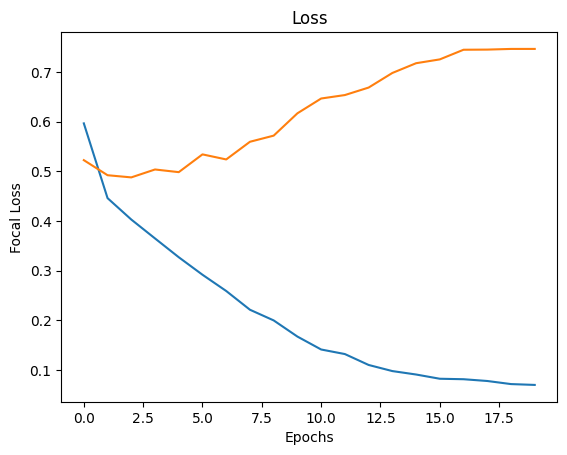

In [3]:
train_data = PokemonDataset(["image:default", "types"], transform={"image:default": transforms.Compose([
    transforms.Resize((480,480)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])}).query("pokedex_id <= 900")
test_data = PokemonDataset(["image:default", "types"],transform={"image:default": transforms.Compose([
    transforms.Resize((480,480)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])}).query("pokedex_id > 900")
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

model = TypeDiscriminator(18).to(device)
optimizer = torch.optim.AdamW([
    {"params": model.classifier.parameters(), "lr": 1e-3},
    {"params": model.backbone.parameters(), "lr": 1e-5}
], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 20, 1e-6)
loss_func = sigmoid_focal_loss


train_loss_log = []
val_loss_log = []

model.train()
for epoch in range(20):
    model.train()
    total_loss = 0
    for img, label in tqdm(train_loader):
        img = img.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        pred = model(img)
        loss = loss_func(pred, label.type(torch.float32).to(device), reduction='sum')
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss_log.append(total_loss / len(train_loader.dataset))

    model.eval()
    with torch.no_grad():
        total_loss = 0
        for img, label in test_loader:
            img = img.to(device)
            label = label.to(device)
            pred = model(img)
            loss = loss_func(pred, label.type(torch.float32).to(device), reduction='sum')
            total_loss += loss.item()
        val_loss_log.append(total_loss / len(test_loader.dataset))

    print(f"Epoch {epoch+1}, Train Loss: {train_loss_log[-1]:.4f}, Validation Loss: {val_loss_log[-1]:.4f}")
    scheduler.step()

plt.plot(train_loss_log)
plt.plot(val_loss_log)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Focal Loss")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


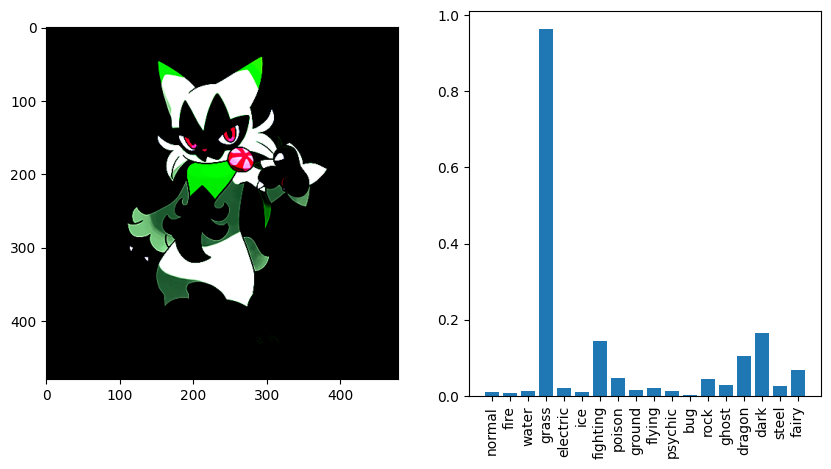

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


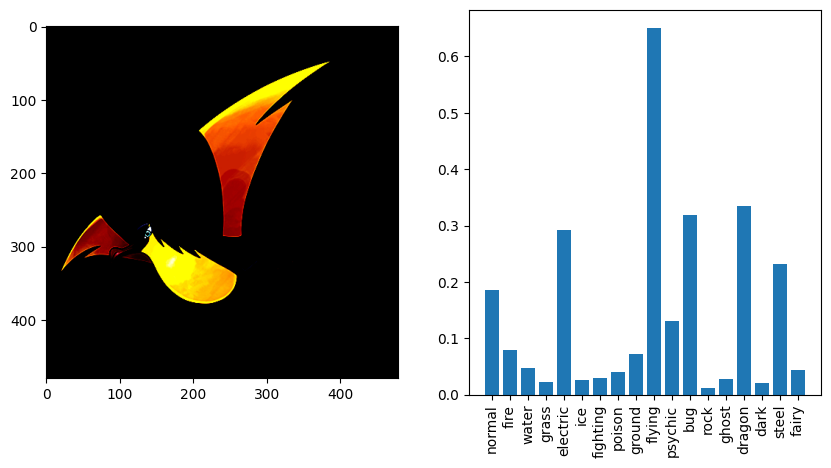

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


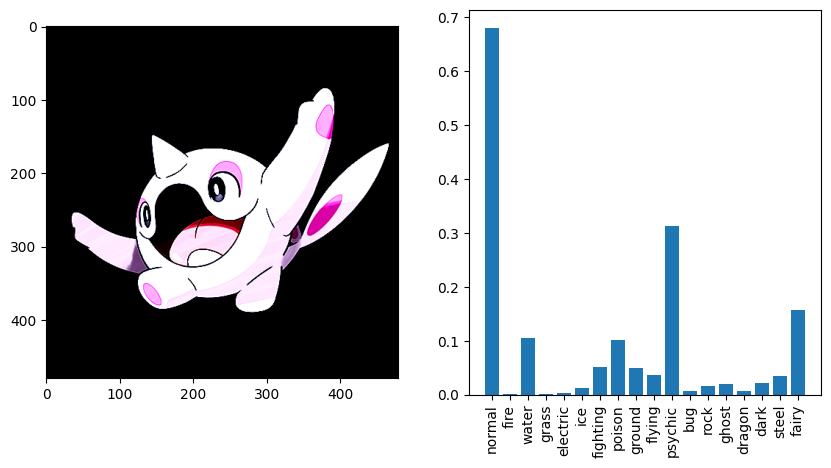

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


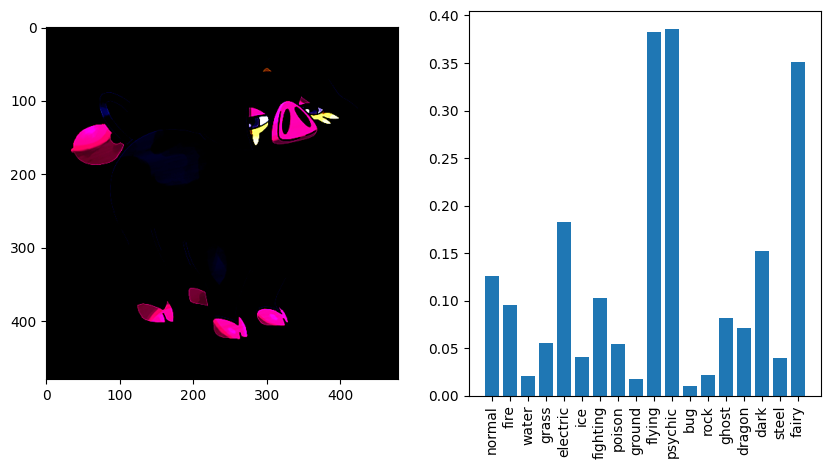

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


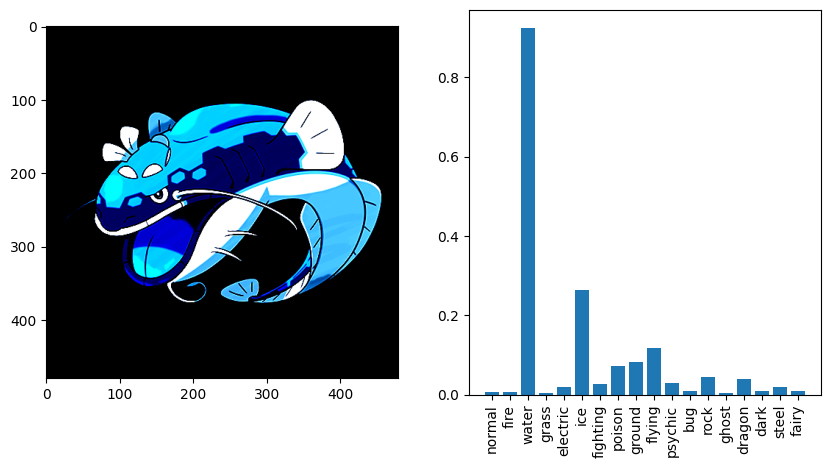

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


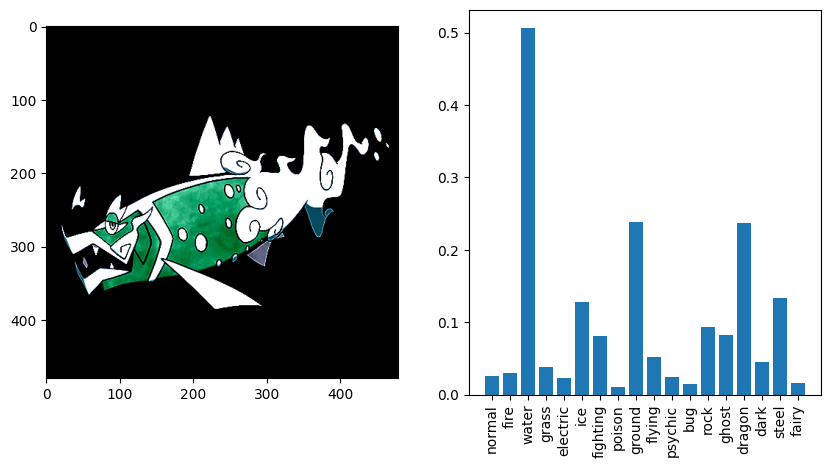

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


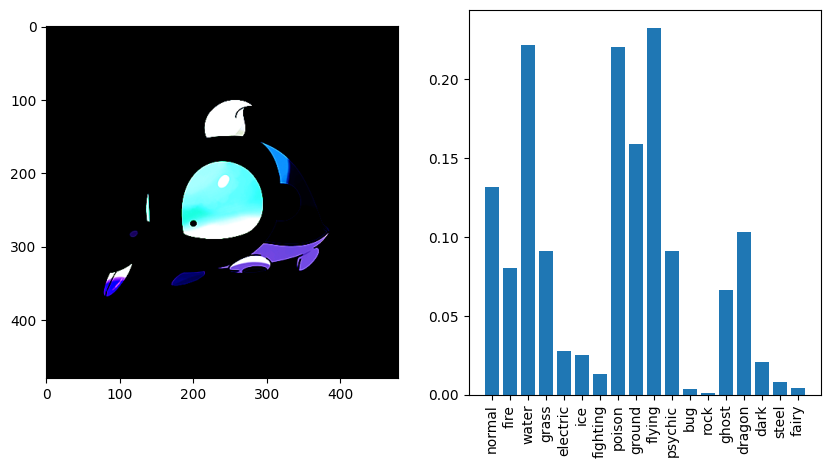

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


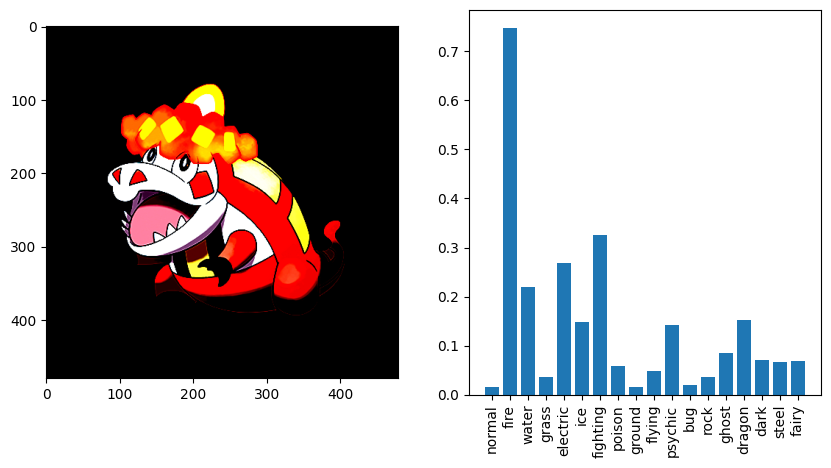

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


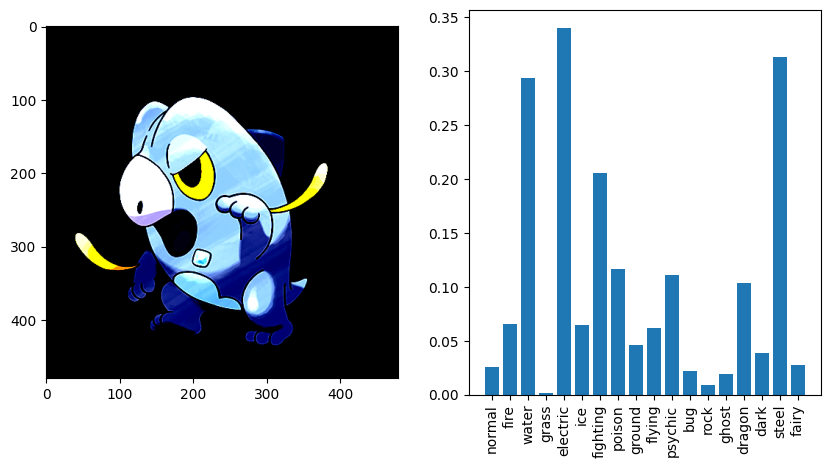

Exact Match Accuracy : 0.0839
Hamming Accuracy     : 0.9126
F1 Score (micro)     : 0.2718
F1 Score (macro)     : 0.2128
Mean Avg Precision   : 0.3235


In [5]:
all_labels = []
all_preds = []
all_probs = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        fig,ax = plt.subplots(1,2, figsize=(10, 5))
        ax.flat[0].imshow(imgs[0].permute(1,2,0))

        imgs = imgs.to(device)
        outputs = model(imgs)  # shape: (B, 18)
        probs = torch.sigmoid(outputs)
        preds = probs > 0.5

        all_labels.append(labels.cpu())
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

        ax.flat[1].bar(list(TYPES.keys()), probs.cpu()[0].tolist())
        plt.xticks(rotation=90)
        plt.show()

y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()
y_prob = torch.cat(all_probs).numpy()

# 評価指標
exact_match = (y_true == y_pred).all(axis=1).mean()  # 全ラベル一致率
hamming_acc = (y_true == y_pred).mean()              # ラベル単位の一致率（Hamming accuracy）
f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
map_score = average_precision_score(y_true, y_prob, average='macro')

print(f"Exact Match Accuracy : {exact_match:.4f}")
print(f"Hamming Accuracy     : {hamming_acc:.4f}")
print(f"F1 Score (micro)     : {f1_micro:.4f}")
print(f"F1 Score (macro)     : {f1_macro:.4f}")
print(f"Mean Avg Precision   : {map_score:.4f}")